In [37]:
import numpy as np
import pymc3 as pm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("talk")

In [35]:
def sigmoid(x, a, b, c):
    return a / (1 + np.exp(-(x - c) / b))


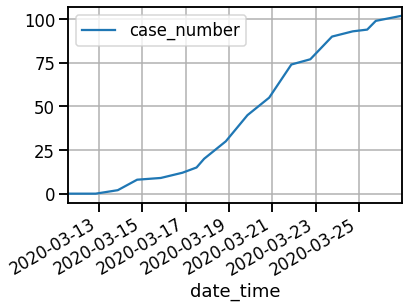

In [38]:
PLACEHOLDER_TIME = "23:59"

df = pd.read_csv("./jena_covid19_scraped.csv").replace({"time": {"None": PLACEHOLDER_TIME}})
df["date_time"] = pd.to_datetime(df["date"] + " " + df["time"])
df.plot(x="date_time", y="case_number")
plt.grid("on")

Let's convert time stamps to the number of days and normalize the variables

In [4]:
dt = df.date_time - df.date_time[0]
day = np.timedelta64(1, "D")
x = (dt / day).values
y = df.case_number.values.astype(float)

In [5]:
mu_x = x.mean()
sigma_x = x.std()
ymax = y.max()
xn = (x - mu_x) / sigma_x
yn = y / ymax

# Logistic

In [60]:
n_dropped = [0, 1, 3, 5, 7]

In [65]:
xpp = np.linspace(0, 20)
traces = {}
for n in n_dropped:
    with pm.Model() as model:
        a = pm.Normal("a", mu=1, sd=1)
        b = pm.Normal("b", mu=1, sd=1)
        c = pm.Normal("c", mu=0, sd=1)
        eps = pm.HalfCauchy("eps", beta=1)
        mu = pm.Deterministic("y", a / (1 + pm.math.exp(-(xn[:-n-1] - c) / b)))
        y_like = pm.Normal('y_like', mu=mu, sd=eps, observed=yn[:-n-1])

        traces[n] = pm.sample()
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, c, b, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1602.81draws/s]
The acceptance probability does not match the target. It is 0.8941081821984093, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, c, b, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1607.96draws/s]
The acceptance probability does not match the target. It is 0.8936564867085542, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, c, b, a]
Sampling 4 chains, 2 

In [67]:
ypps = {}
y_mean = {}

In [69]:
for n in n_dropped:
    ypps[n] = sigmoid(xpp[:, None], 
                      traces[n]["a"][None, ::5] * ymax, 
                      traces[n]["b"][None, ::5] * sigma_x, 
                      traces[n]["c"][None, ::5] * sigma_x + mu_x)
    y_mean[n] = sigmoid(xpp[:, None], 
                      traces[n]["a"][None, :].mean() * ymax, 
                      traces[n]["b"][None, :].mean() * sigma_x, 
                      traces[n]["c"][None, :].mean() * sigma_x + mu_x)

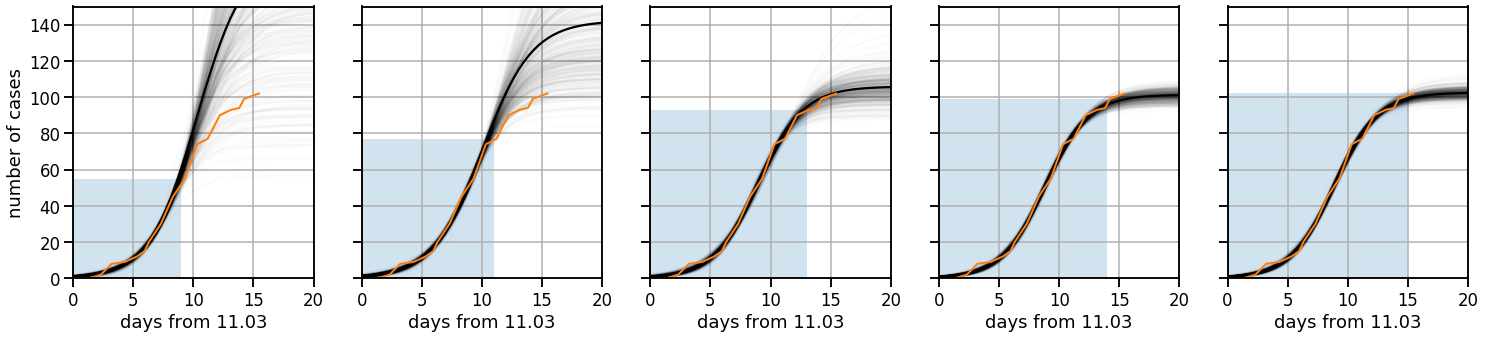

In [72]:
fig, axes = plt.subplots(ncols=len(n_dropped), figsize=(25, 5), sharey=True, sharex=True)
for ax, n in zip(axes, reversed(n_dropped)):
    ax.plot(xpp, ypps[n][:,0], c="k", alpha=.01, label="posterior prediciton");
    ax.plot(xpp, ypps[n][:,1:], c="k", alpha=.01);
    ax.plot(xpp, y_mean[n], c="k", alpha=1);
    ax.plot(x, y, linewidth=2, c="C1", label="data");
    ax.fill_between(np.arange(x[-n-1]), y[-n-1], alpha=.2)#, linestyle="--", c="C0")
    ax.grid("on")
    ax.set_xlabel("days from 11.03")
axes[0].set_ylabel("number of cases")
axes[0].set_ylim([0,150])
axes[0].set_xlim([0,xpp[-1]])
plt.savefig("./sigmoid_bayes_incomplete.png", dpi=150, bbox_inches="tight")